# Preparation Machine Learning

Now that we pre-processed our fMRI data in the previous [Pre-processing Hands-On Notebook](handson_preprocessing.ipynb), we are ready for further analysis. So let's consider some machine learning approaches.

## What do we want to do?

We have from each subject two different resting-state runs. Once where they have their eyes **closed** an once where they have their eyes **open**. At least around the eyes we can see a clear difference:

<img src="./data/resting_state_eyes.gif" style="width:500px;">

With such an obvious signal difference we should be able to classify the two categoires `'closed'` and `'open'`. But before we can do any machine learning we need to prepare the data accordingly.

## Why do we need to prepare the data?

Let's take a look at the data of one subject:

In [1]:
from nilearn.plotting import plot_anat
%matplotlib inline
import nibabel as nb

/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


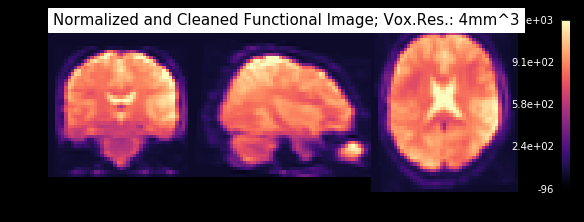

In [2]:
img_func = nb.load('/output/datasink/preproc/sub-01_task-rest-EC_smooth.nii.gz')
plot_anat(img_func.slicer[..., 0], dim='auto', draw_cross=False, annotate=False,
          cmap='magma', vmax=1250, cut_coords=[33, -20, 20], colorbar=True,
          title='Normalized and Cleaned Functional Image; Vox.Res.: 4mm^3')

This all looks fine. Why do we need to prepare something? Well, let's take a look at two things.

### 1. What does the signal time-course of a voxel look like?

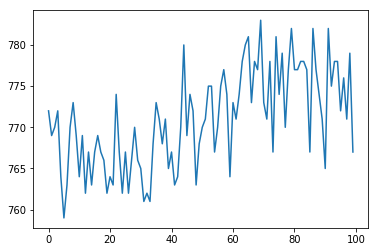

In [3]:
from matplotlib.pyplot import plot
plot(img_func.get_data()[19, 16, 17, :])

As we can see, the data still has a slight linear trend and is centered around a value of 770 (for this particular voxel). To be able to do some machine learning on this data we therefore need to remove the linear trend and ideally zscore the data.

This can be done with the following commands:

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


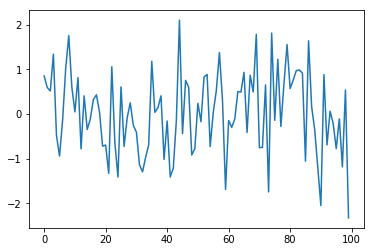

In [4]:
import numpy as np
from scipy.signal import detrend
from scipy.stats import zscore

# Detrend and zscore the data
data = img_func.get_data()
data = detrend(data)
data = np.nan_to_num(zscore(data, axis=0))

# Plot the cleaned signal
plot(data[19, 16, 17, :]);

Perfect, that looks much better!

### 2. How many nonzero voxels do we have?

In [5]:
np.sum(img_func.get_data().mean(axis=-1)!=0)

109350

Well, those are all voxels of the 45 x 54 x 45 matrix. It doesn't make sense that we run machine learning outside of the brain.

So let's use a mask to only keep those voxels that we're interested in. For this purpose we will use the MNI-152 template brain mask and an eye mask that we've created for this workshop. Both can be found under `/templates`:

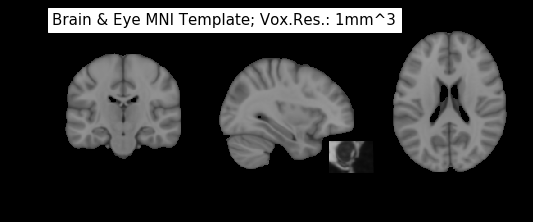

In [6]:
from nilearn.image import math_img

# Specify location of the brain and eye image
brain = '/templates/MNI152_T1_1mm_brain.nii.gz'
eyes = '/templates/MNI152_T1_1mm_eye.nii.gz'

# Combine the two template images
img_roi = math_img("img1 + img2", img1=brain, img2=eyes)

# Plot the region-of-interest (ROI) template
plot_anat(img_roi, dim='auto', draw_cross=False, annotate=False,
          cut_coords=[33, -20, 20], title='Brain & Eye MNI Template; Vox.Res.: 1mm^3')

Great, now we just need to binarize this template to get a mask, dilate this mask a bit to be sure that we keep all relevant voxels and multiply it with the functional image. But before we can do any of this we also need to resample the ROI template to a voxel resolution fof 4x4x4mm, as the functional images.

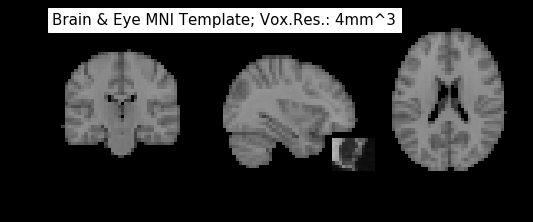

In [7]:
# Resample ROI template to functional image resolution
from nilearn.image import resample_to_img

img_resampled = resample_to_img(img_roi, img_func)

plot_anat(img_resampled, dim='auto', draw_cross=False, annotate=False,
          cut_coords=[33, -20, 20], title='Brain & Eye MNI Template; Vox.Res.: 4mm^3')

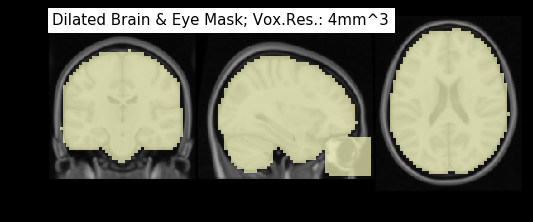

In [8]:
from scipy.ndimage import binary_dilation

# Binarize ROI template
data_binary = np.array(img_resampled.get_data()>=10, dtype=np.int8)

# Dilate binary mask once
data_dilated = binary_dilation(data_binary, iterations=1).astype(np.int8)

# Save binary mask in NIfTI image
img_mask = nb.Nifti1Image(data_dilated, img_resampled.affine, img_resampled.header)
img_mask.set_data_dtype('i1')

# Plot binary mask (overlayed over MNI-152_Template)
from nilearn.plotting import plot_roi
plot_roi(img_mask, draw_cross=False, annotate=False, black_bg=True,
         bg_img='/templates/MNI152_T1_1mm.nii.gz', cut_coords=[33, -20, 20],
         title='Dilated Brain & Eye Mask; Vox.Res.: 4mm^3', cmap='magma_r', dim=1)

Cool. How many voxels do we have now?

In [9]:
np.sum(img_mask.get_data())

37398

Great, that's a 66% reduction of datapoints that we need to consider in our machine-learning approach!

Now we only have to multiply this mask with our functional images and remove tailing zeros from the 3D matrix.

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/image/image.py:314: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped_data = data[slices]


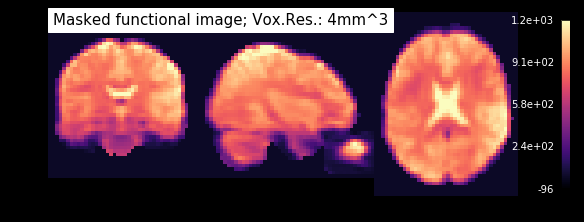

In [10]:
# Multiply the functional image with the mask
img_cleaned = math_img('img1 * img2', img1=img_func, img2=img_mask.slicer[..., None])

# Remove as many zero rows in the data matrix to reduce overall volume size
from nilearn.image import crop_img
img_crop = crop_img(img_cleaned)

# Plot the 
from nilearn.plotting import plot_anat
plot_anat(img_crop.slicer[..., 0], dim='auto', draw_cross=False, annotate=False,
          cmap='magma', vmax=1250, cut_coords=[33, -20, 20], colorbar=True,
          title='Masked functional image; Vox.Res.: 4mm^3')

## Preparing the data

If we do all the steps that we discussed above in one go, it looks like this:

In [11]:
in_file = '/output/datasink/preproc/sub-01_task-rest-EC_smooth.nii.gz'

In [12]:
# Load functional image
img_func = nb.load(in_file)

# Detrend and zscore data and save it under a new NIfTI file
data = img_func.get_data()
data = detrend(data)
data = np.nan_to_num(zscore(data, axis=0))
img_standardized = nb.Nifti1Image(data, img_func.affine, img_func.header)

# Create MNI-152 template brain and eye mask
brain = '/templates/MNI152_T1_1mm_brain.nii.gz'
eyes = '/templates/MNI152_T1_1mm_eye.nii.gz'
img_roi = math_img("img1 + img2", img1=brain, img2=eyes)
img_resampled = resample_to_img(img_roi, img_func)
data_binary = np.array(img_resampled.get_data()>=10, dtype=np.int8)
data_dilated = binary_dilation(data_binary, iterations=1).astype(np.int8)
img_mask = nb.Nifti1Image(data_dilated, img_resampled.affine, img_resampled.header)
img_mask.set_data_dtype('i1')

# Multiply functional image with mask and crop image
img_cleaned = math_img('img1 * img2',
                       img1=img_standardized, img2=img_mask.slicer[..., None])
img_crop = crop_img(img_cleaned)

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/image/image.py:314: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped_data = data[slices]


And the result looks as follows:

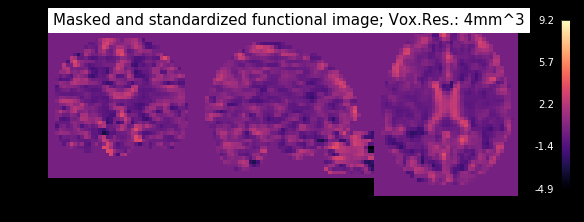

In [13]:
plot_anat(img_crop.slicer[..., 0], dim='auto', draw_cross=False, annotate=False,
          cmap='magma', cut_coords=[33, -20, 20], colorbar=True,
          title='Masked and standardized functional image; Vox.Res.: 4mm^3')

# Creating the machine learning dataset

Above we showed you how to prepare the data of an individual run for machine-learning. We now could use the 100 volumes per run and try to do machine learning on this. But this might not be the best approach.

Let's consider again what we want to do. We want to predict if a person has their eyes closed or open during a resting state scan. Our assumption is that during the **eyes open** there is more eye movement, more visual stimulation, i.e. more variance in certain regions. Therefore, we want to look at the standard deviation over time (i.e. over the 100 volumes per run).

**Keep in mind** that this approach is more or less "randomly" chosen by us to be appropriate for this particular classification and might differ a lot to other datasets, research questions etc.

To nonetheless keep enough data points, let's take the 100 volumes, and compute the standard deviation for 4 equally long sections:

In [14]:
img_std1 = nb.Nifti1Image(img_crop.get_data()[...,0:25].std(axis=-1), img_crop.affine, img_crop.header)
img_std2 = nb.Nifti1Image(img_crop.get_data()[...,25:50].std(axis=-1), img_crop.affine, img_crop.header)
img_std3 = nb.Nifti1Image(img_crop.get_data()[...,50:75].std(axis=-1), img_crop.affine, img_crop.header)
img_std4 = nb.Nifti1Image(img_crop.get_data()[...,75:100].std(axis=-1), img_crop.affine, img_crop.header)

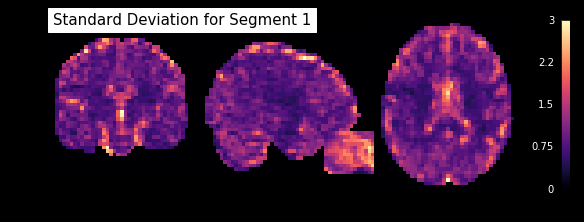

In [15]:
plot_anat(img_std1, draw_cross=False, annotate=False, cmap='magma',
          cut_coords=[33, -20, 20], vmax=3, colorbar=True,
          title='Standard Deviation for Segment 1')

If we do this now for each of the eyes **closed** and **open** run, for each of the total 48 subjects in the dataset, we will get 4 segments x 2 eye_state x 48 subjects = 384 datapoints per voxel. The pre-processing of all 48 subjects would explode the scope of this workshop, we therefore already pre-processed all subjects and prepared the data for the machine-learning approach.

### The dataset ready for the machine-learning approach can be found under:

`/home/neuro/notebooks/data/dataset_ML.nii.gz`